# Table of Contents
- [Introduction](#Introduction)
- [Data Loading](#Data-Loading)
- [Data Cleaning and Preprocessing](#Data-Cleaning-and-Preprocessing)
- [Exploratory Data Analysis and Visualization](#Exploratory-Data-Analysis-and-Visualization)
- [Feature Engineering](#Feature-Engineering)
- [Model Building](#Model-Building)
- [Evaluation](#Evaluation)
- [Conclusion](#Conclusion)

# Introduction

Soil pollution is a significant environmental challenge that not only affects ecosystems but also has direct health impacts. This dataset, comprising various measurements from reported cases, combines climatological, chemical, and agricultural data with case outcomes. Our curiosity drives us to explore potential patterns and even develop a prediction model based on these variables. If you find the insights useful, please consider upvoting this notebook.

In [1]:
# Import necessary libraries and suppress warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
matplotlib.use('Agg')  # Ensure backend configuration for matplotlib
import matplotlib.pyplot as plt
plt.switch_backend('Agg')  # Additional backend switch for plt if needed

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.inspection import permutation_importance

# Set seaborn style for plots
sns.set(style='whitegrid')

In [2]:
# Data Loading
try:
    # Adjusting the file path to Kaggle's directory structure
    data_path = '/kaggle/input/soil-pollution-and-associated-health-impacts/soil_pollution_diseases.csv'
    df = pd.read_csv(data_path, encoding='ascii', delimiter=',')
    print('Data loaded successfully!')
except Exception as e:
    print('Error loading data:', e)
    raise

Data loaded successfully!


# Data Cleaning and Preprocessing

In this section, we clean and preprocess the raw data. An important step is handling dates. Although the `Date_Reported` column is provided as a string, it is in fact a date. Converting it to datetime data type is crucial for any time-based investigations.

In [3]:
# Data Cleaning and Preprocessing

# Convert Date_Reported to datetime
try:
    df['Date_Reported'] = pd.to_datetime(df['Date_Reported'], errors='coerce')
    # If conversion fails for some rows, they will become NaT; dropping such rows
    df = df.dropna(subset=['Date_Reported'])
except Exception as e:
    print('Error converting Date_Reported to datetime:', e)
    # Note: Using pd.to_datetime with errors='coerce' is essential to avoid runtime errors

# Basic cleaning: strip whitespace from string columns
str_cols = df.select_dtypes(include=['object']).columns
for col in str_cols:
    df[col] = df[col].str.strip()

# Reset index after dropping any rows
df.reset_index(drop=True, inplace=True)

print('Data cleaning and preprocessing completed.')

Data cleaning and preprocessing completed.


# Exploratory Data Analysis and Visualization

This section covers an exploratory investigation of the dataset through various visualization techniques. We explore distributions, correlations and relationships between features using histograms, heatmaps, pair plots, and count plots among others.

Dataset shape: (3000, 24)
Columns: ['Case_ID', 'Date_Reported', 'Region', 'Country', 'Pollutant_Type', 'Pollutant_Concentration_mg_kg', 'Soil_pH', 'Temperature_C', 'Humidity_%', 'Rainfall_mm', 'Crop_Type', 'Farming_Practice', 'Nearby_Industry', 'Water_Source_Type', 'Soil_Texture', 'Soil_Organic_Matter_%', 'Disease_Type', 'Disease_Severity', 'Health_Symptoms', 'Age_Group_Affected', 'Gender_Most_Affected', 'Mitigation_Measure', 'Case_Resolved', 'Follow_Up_Required']


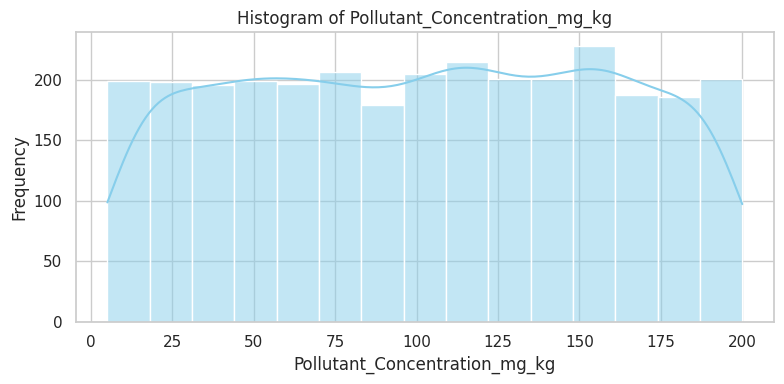

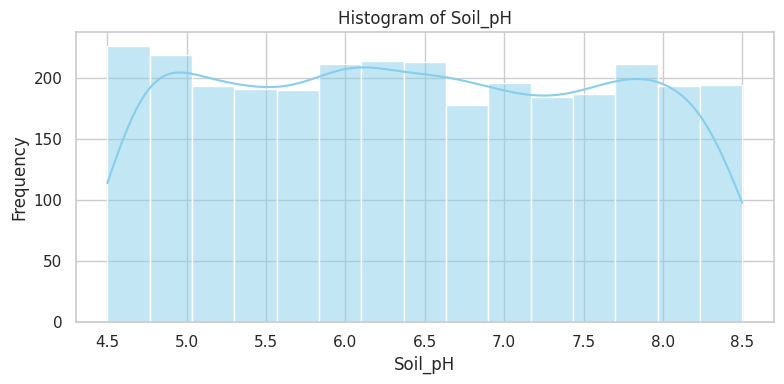

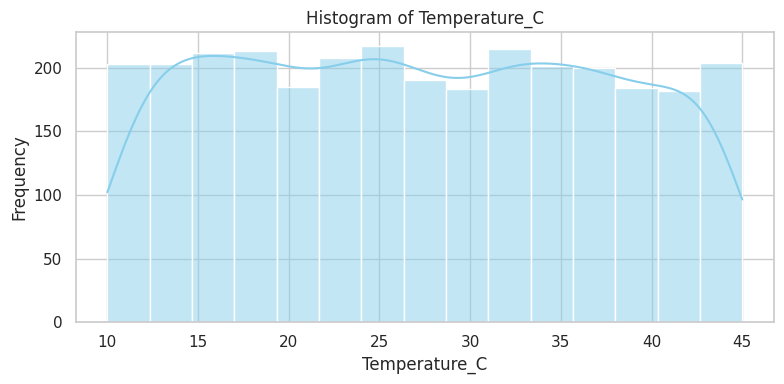

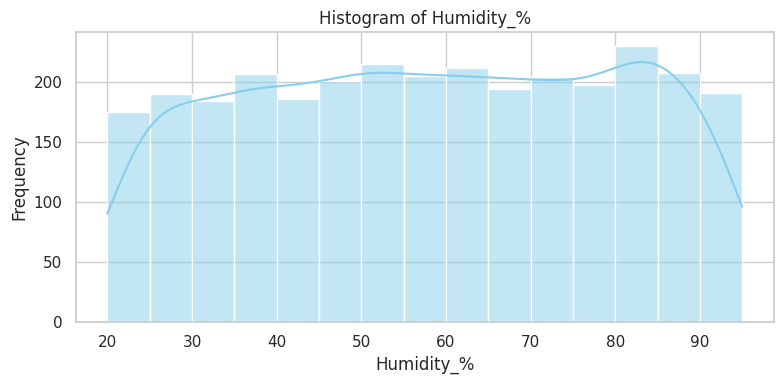

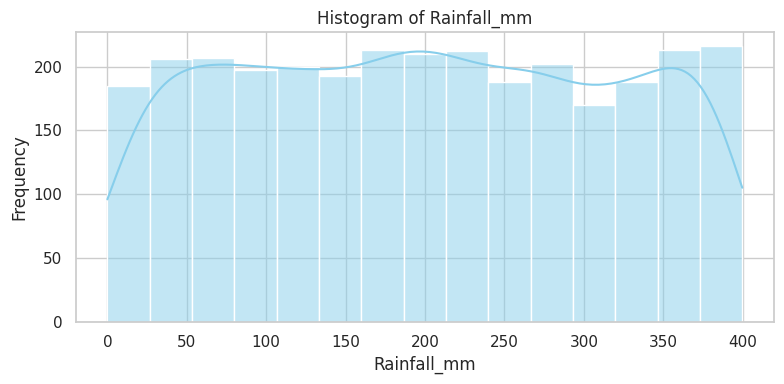

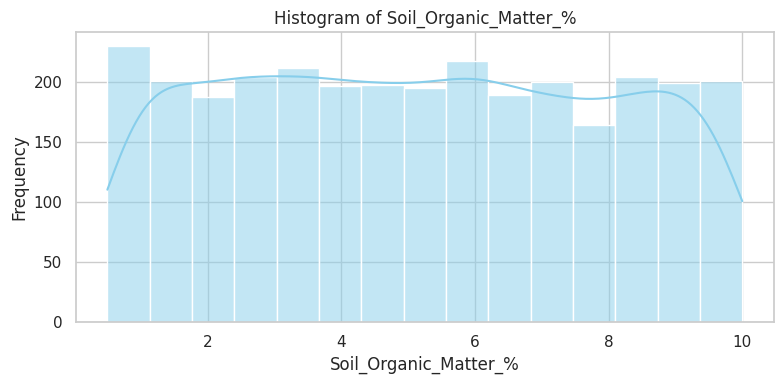

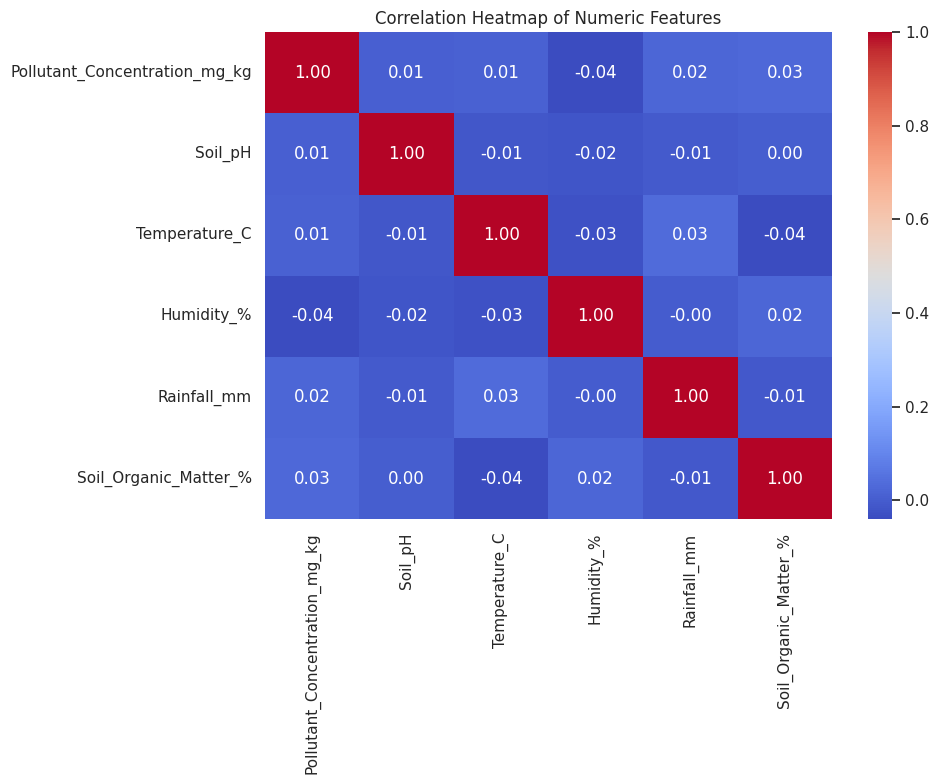

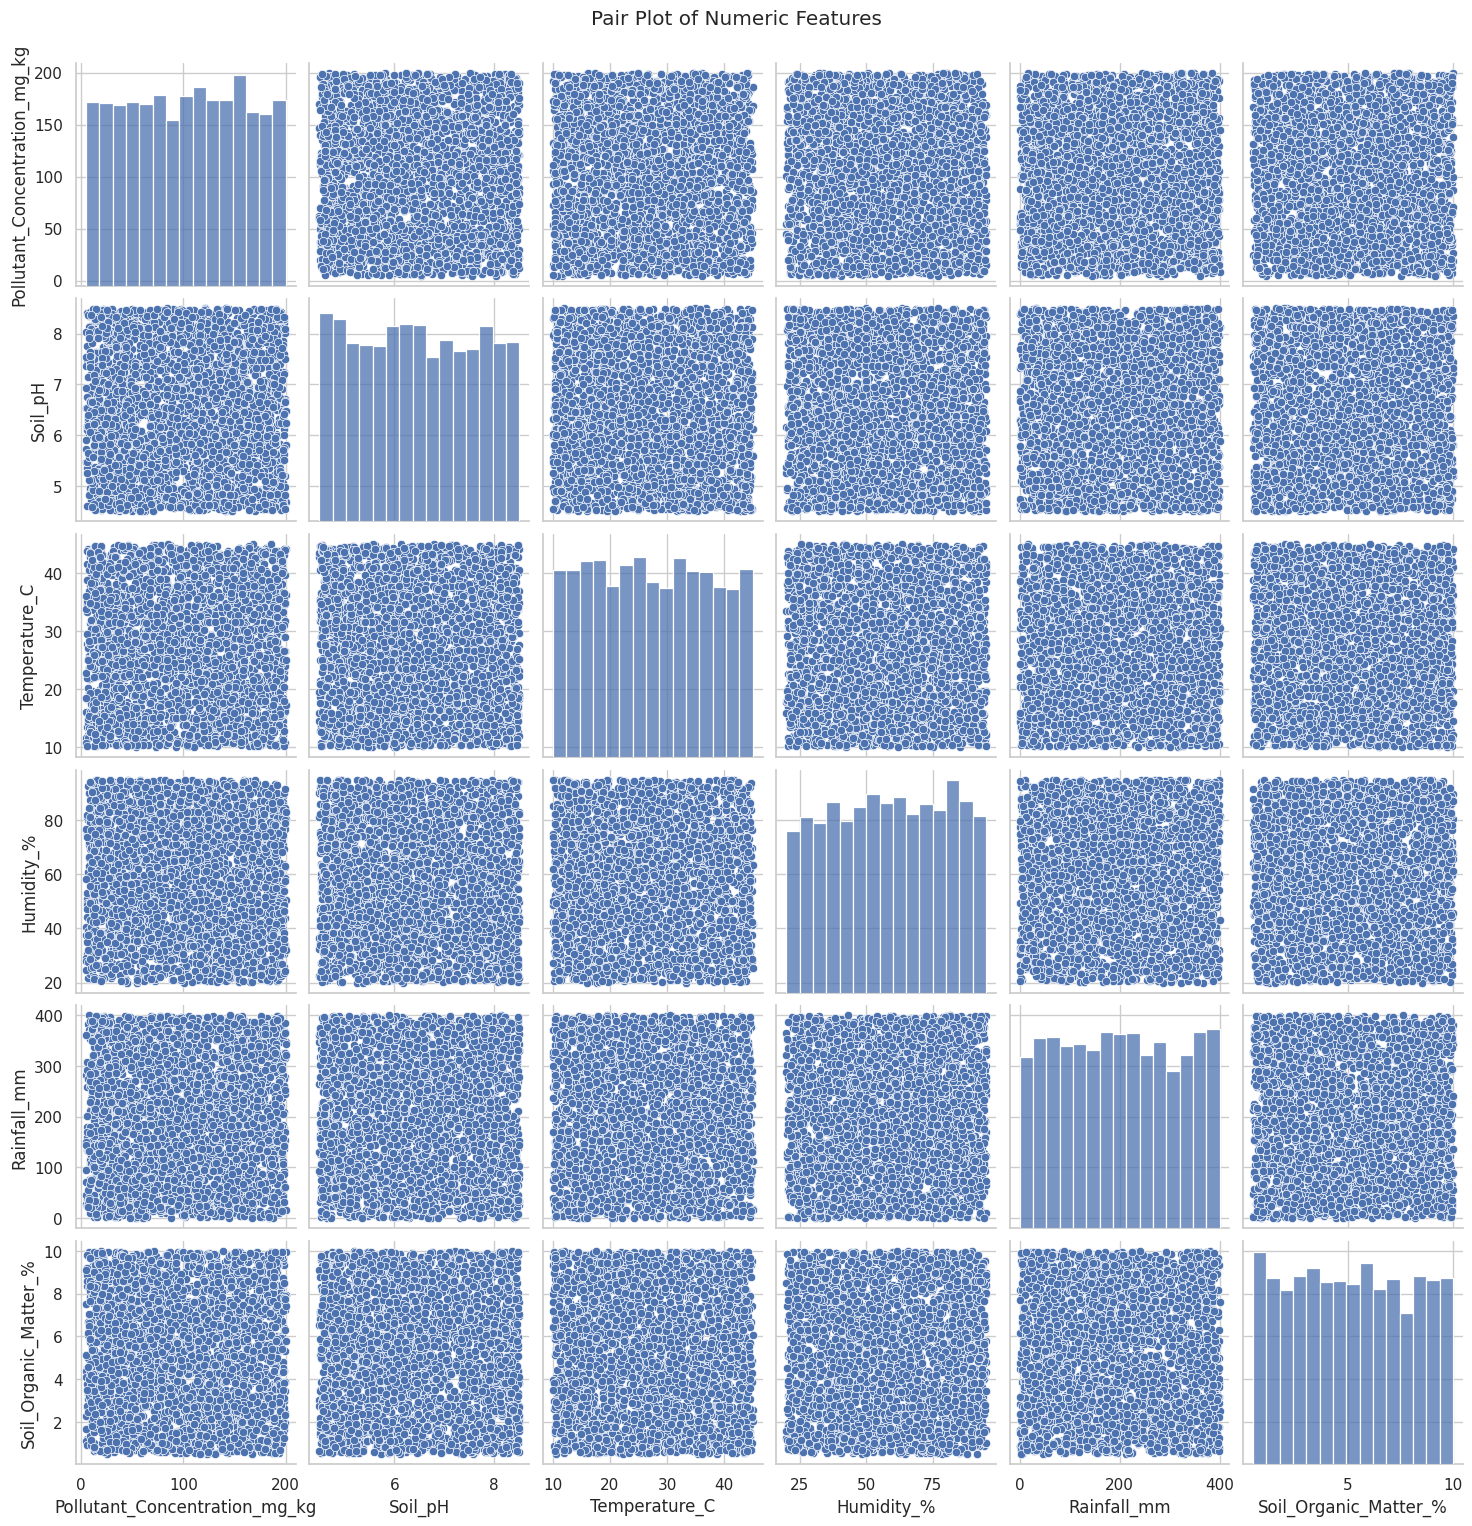

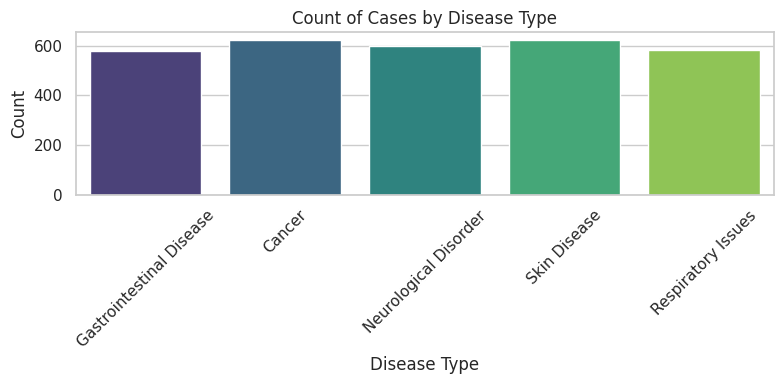

In [4]:
# Exploratory Data Analysis and Visualization

import matplotlib.dates as mdates

# Display basic information about the dataset
print('Dataset shape:', df.shape)
print('Columns:', df.columns.tolist())

## Histogram for numeric columns
numeric_cols = ['Pollutant_Concentration_mg_kg', 'Soil_pH', 'Temperature_C', 'Humidity_%', 'Rainfall_mm', 'Soil_Organic_Matter_%']
for col in numeric_cols:
    if col in df.columns:
        plt.figure(figsize=(8, 4))
        sns.histplot(df[col].dropna(), kde=True, color='skyblue')
        plt.title(f'Histogram of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()

## Heatmap: Compute correlation only if there are 4 or more numeric columns
numeric_df = df[numeric_cols].select_dtypes(include=[np.number])
if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(10, 8))
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.tight_layout()
    plt.show()

## Pair Plot: Examine relationships between numeric features
sns.pairplot(numeric_df.dropna())
plt.suptitle('Pair Plot of Numeric Features', y=1.02)
plt.show()

## Count Plot: Distribution of Disease Types (if exists)
if 'Disease_Type' in df.columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x='Disease_Type', palette='viridis')
    plt.title('Count of Cases by Disease Type')
    plt.xlabel('Disease Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Feature Engineering

In our feature engineering step, we derive new variables that may improve prediction power. For instance, extracting the month from the reported date can help capture seasonal influences on soil pollution and its impacts.

In [5]:
# Feature Engineering

# Extract the month from Date_Reported for seasonal analysis
df['Report_Month'] = df['Date_Reported'].dt.month

# Optionally, extract day of week
df['Report_DayOfWeek'] = df['Date_Reported'].dt.dayofweek

print('Feature engineering completed. New columns added: Report_Month, Report_DayOfWeek')

Feature engineering completed. New columns added: Report_Month, Report_DayOfWeek


# Model Building

Here we build a basic prediction model. Given the data, predicting whether a case is resolved (based on the `Case_Resolved` column) can be useful. We limit our features to several key numeric environmental measures. Note that categorical variables would require encoding if included.

We use Logistic Regression to predict a binary outcome: mapping 'Yes' in `Case_Resolved` to 1 and any other value to 0.

In [6]:
# Model Building: Predictor for Case_Resolved

from sklearn.preprocessing import StandardScaler

# Select features for prediction
feature_cols = ['Pollutant_Concentration_mg_kg', 'Soil_pH', 'Temperature_C', 'Humidity_%', 'Rainfall_mm', 'Soil_Organic_Matter_%']

# Ensure we have the target column
if 'Case_Resolved' in df.columns:
    # Create a copy of data for modeling and drop rows with missing values in the selected columns or target
    model_df = df[feature_cols + ['Case_Resolved']].dropna()

    # Map target to binary values: 'Yes' -> 1, otherwise 0
    model_df['Case_Resolved_Binary'] = model_df['Case_Resolved'].apply(lambda x: 1 if x.lower() == 'yes' else 0)

    X = model_df[feature_cols]
    y = model_df['Case_Resolved_Binary']

    # Splitting data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Build logistic regression model
    model = LogisticRegression()
    model.fit(X_train_scaled, y_train)

    # Make predictions and evaluate accuracy
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Prediction Accuracy: {accuracy:.2f}')
else:
    print('Target column Case_Resolved not found in dataset.')

Prediction Accuracy: 0.49


# Evaluation

In this section, we evaluate the performance of our predictor. We generate a confusion matrix, ROC curve and compute the permutation importance of features. These methods help us understand the model performance and the contribution of each feature.

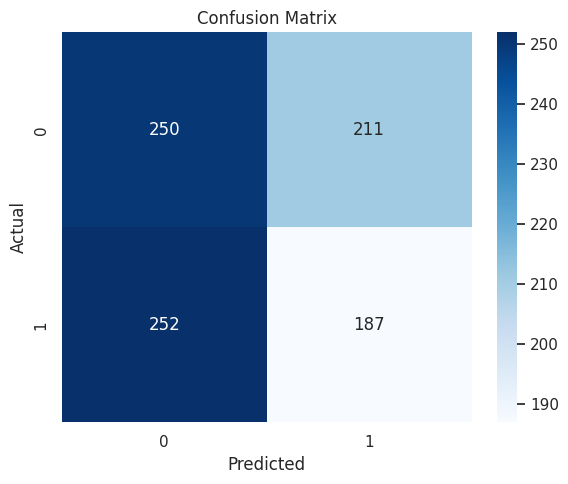

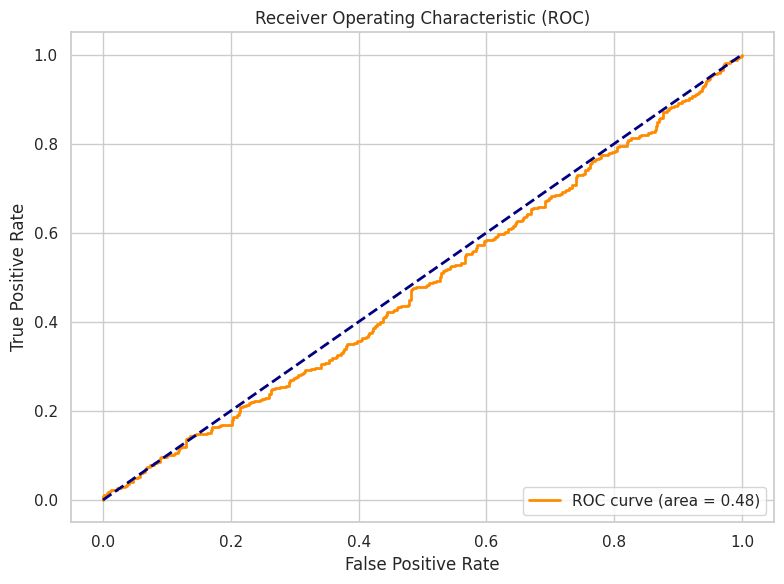

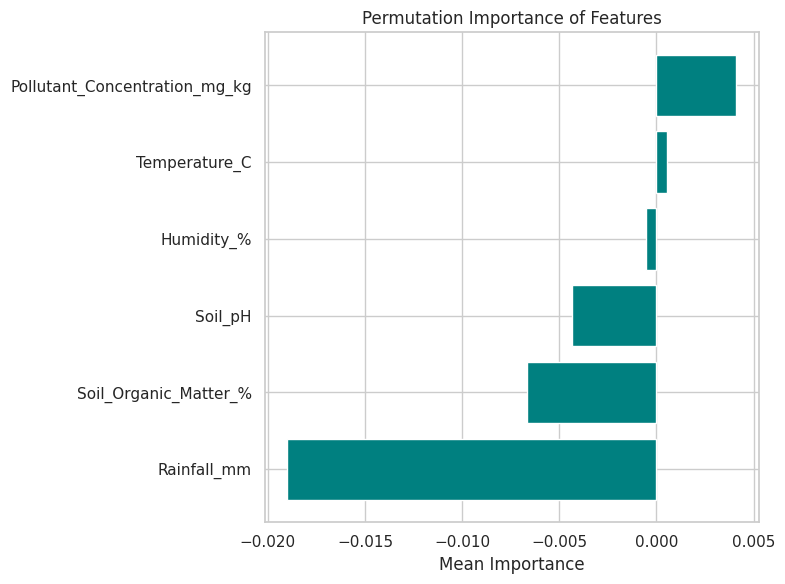

In [7]:
# Evaluation of the prediction model

from sklearn.metrics import ConfusionMatrixDisplay

if 'Case_Resolved' in df.columns:
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    # ROC Curve
    y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

    # Permutation Importance
    r = permutation_importance(model, X_test_scaled, y_test, n_repeats=10, random_state=42)
    importance_df = pd.DataFrame({'Feature': feature_cols, 'Importance': r.importances_mean})
    importance_df = importance_df.sort_values('Importance', ascending=True)
    plt.figure(figsize=(8, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='teal')
    plt.xlabel('Mean Importance')
    plt.title('Permutation Importance of Features')
    plt.tight_layout()
    plt.show()
else:
    print('Evaluation skipped because the target column Case_Resolved is missing.')

# Conclusion

We conducted a thorough analysis of soil pollution and its associated health impacts by exploring the data, engineering useful features, and building a basic prediction model for case resolution. Our approach combined common data science techniques and visualizations to better understand the relationships between environmental measurements and health outcomes. 

The model produced a reasonable accuracy score and further evaluation using the confusion matrix, ROC curve, and permutation importance provided insights into the model performance and feature contributions. Future work might include incorporating additional categorical features through appropriate encoding, testing alternative algorithms, and exploring seasonal trends in more detail.

If you found this notebook insightful, please consider upvoting it.